## 4.1 简介
无监督学习是一种对不含标记的数据建立模型的机器学习范式。到目前为止，我们处理的数 据都带有某种形式的标记，也就是说，学习算法可以根据标记看到这些数据，并对数据进行分类。 但是，在无监督学习的世界中，我们没有这样的条件了。当需要用一些相似性指标对数据集进行 分组时，就会用到这些算法了。
最常见的无监督学习方法就是聚类，你一定对这个词耳熟能详。当需要把无标记的数据分成 几种集群时，就要用它来分析。这些集群通常是根据某种相似度指标进行划分的，例如欧氏距离
(Euclidean distance)。无监督学习广泛应用于各种领域，如数据挖掘、医学影像、股票市场分析、 计算机视觉、市场细分等。

## 4.2 用kmeans聚类数据
详细步骤

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.cluster import KMeans

In [10]:
data= pd.read_csv('data_multivar.txt',header=None)
data.head()

,0,1
0,1.96,-0.09
1,2.84,3.16
2,4.74,1.84
3,6.36,4.89
4,1.77,1.55


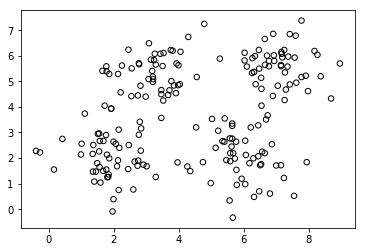

In [14]:
plt.scatter(data.iloc[:,0],data.iloc[:,1],marker='o',edgecolors='k',s=30,facecolors='none')

In [15]:
#定义簇数
num_cluster=4
kmeans=KMeans(init='k-means++',n_clusters=num_cluster,n_init=10)
kmeans.fit(data)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=4, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

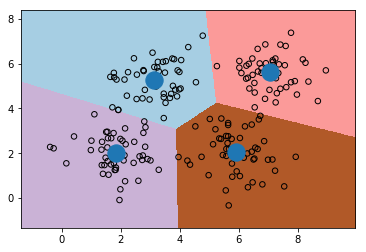

In [23]:
def plot_meshgrid(cluster,data):
    step_size=0.01
    x_min,x_max=data[0].min()-1,data[0].max()+1
    y_min,y_max=data[1].min()-1,data[1].max()+1
    x_values,y_values=np.meshgrid(np.arange(x_min,x_max,step_size),np.arange(y_min,y_max,step_size))
    predict_labels=cluster.predict(np.c_[x_values.ravel(),y_values.ravel()])
    predict_labels=predict_labels.reshape(x_values.shape)
    plt.clf()
    plt.imshow(predict_labels,interpolation='nearest',extent=(x_min,x_max,y_min,y_max),cmap=plt.cm.Paired,aspect='auto',origin='lower')
    plt.scatter(data[0],data[1],marker='o',edgecolors='k',facecolor='none',s=30)
    #得到簇中心
    centroids=kmeans.cluster_centers_
    plt.scatter(centroids[:,0],centroids[:,1],marker='o',s=300)
    
    
plot_meshgrid(kmeans,data)

### 简单来说Kmeans通过迭代更新簇中心点

- 随机选取k个点作为初始中心点
- 计算其他点到中心点的距离进行簇划分
- 簇内更新中心点位置
- 迭代直到簇内没有变化

对于k值，可以通过枚举的方式，多次应用计算轮廓系数，

轮廓系数（Silhouette Coefficient）结合了聚类的凝聚度（Cohesion）和分离度（Separation），用于评估聚类的效果。该值处于-1~1之间，值越大，表示聚类效果越好。具体计算方法如下：

- 对于第i个元素$x_i$，计算x_i与其同一个簇内的所有其他元素距离的平均值，记作$a_i$，用于量化簇内的凝聚度。
- 选取$x_i$外的一个簇b，计算x_i与b中所有点的平均距离，遍历所有其他簇，找到最近的这个平均距离,记作$b_i$，用于量化簇之间分离度。
- 对于元素$x_i$，轮廓系数$$s_i = (b_i – a_i)/max(a_i,b_i)$$
- 计算所有x的轮廓系数，求出平均值即为当前聚类的整体轮廓系数
- 从上面的公式，不难发现若$s_i$小于0，说明x_i与其簇内元素的平均距离小于最近的其他簇，表示聚类效果不好。如果$a_i$趋于0，或者$b_i$足够大，那么$s_i$趋近与1，说明聚类效果比较好。

- 当然还需要结合手肘发一同使用判断其是否为最佳

### k-means++

主要区别在于初始化阶段，Kmeans++先随机选取一个点作为簇1的初始点，记下来剩余簇的中心点分别计算所有点距离当前初始点最远的点作为初始点

## 4.3 用矢量量化压缩图片
k-means聚类的主要应用之一就是矢量量化。简单来说，矢量量化就是“四舍五入”(rounding off)的N维版本。在处理数字等一维数据时，会用四舍五入技术减少存储空间。例如，如果只需 要精确到两位小数，那么不会直接存储23.73473572，而是用23.73来代替。如果不关心小数部分， 甚至可以直接存储24，这取决于我们的真实需求。
同理，当把四舍五入这个概念推广到N维数据时，就变成了矢量量化。当然，矢量量化的细 节很多，你可以在http://www.data-compression.com/vq.shtml里学习更多的内容。矢量量化被广泛 应用于图片压缩，我们用比原始图像更少的比特数来存储每个像素，从而实现图像图片。

详细步骤

In [88]:
import argparse
from scipy import misc

## 4.4 建立均值漂移聚类模型
均值漂移是一种非常强大的无监督学习算法，用于集群数据点。该算法把数据点的分布看成 是概率密度函数(probability-density function)，希望在特征空间中根据函数分布特征找出数据点 的“模式”(mode)。这些“模式”就对应于一群群局部最密集(local maxima)分布的点。均值 漂移算法的优点是它不需要事先确定集群的数量。
假设有一组输入点，我们要在不知道要寻找多少集群的情况下找到它们。均值漂移算法就可 以把这些点看成是服从某个概率密度函数的样本。如果这些数据点有集群，那么它们对应于概率 密度函数的峰值。该算法从一个随机点开始，逐渐收敛于各个峰值。你可以在 http://homepages.inf. ed.ac.uk/rbf/CVonline/LOCAL_COPIES/TUZEL1/MeanShift.pdf中学习更详细的内容。

详细步骤


In [89]:
from sklearn.cluster import MeanShift,estimate_bandwidth
X=pd.read_csv('data_multivar.txt',header=None)
bandwidth=estimate_bandwidth(X,quantile=0.1,n_samples=len(X))
meanshift_estimator=MeanShift(bandwidth=bandwidth,bin_seeding=True)
meanshift_estimator.fit(X)
labels=meanshift_estimator.labels_
centroids=meanshift_estimator.cluster_centers_
num_clusters=len(np.unique(labels))
print ("Number of clusters in input data =", num_clusters)

Number of clusters in input data = 4


Text(0.5,1,'Cluster and their centroids')

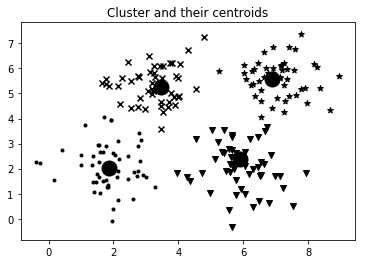

In [90]:
from itertools import cycle
markers='.*xv'
X=np.array(X)
for i,marker in zip(range(num_clusters),markers):
    # 画出属于某个集群中心的数据点
    plt.scatter(X[labels==i, 0], 
                X[labels==i, 1], 
                marker=marker, 
                color='k')
    # 画出集群中心
    centroid = centroids[i]
    plt.plot(centroid[0], 
             centroid[1], 
             marker='o', 
             markerfacecolor='k',
             markeredgecolor='k', 
             markersize=15)
plt.title('Cluster and their centroids')

## 4.5 用凝聚层次聚类进行数据 分组
在介绍凝聚层次聚类之前，我们需要先理解层次聚类(hierarchical clustering)。层次聚类是 一组聚类算法，通过不断地分解或合并集群来构建树状集群(tree-like clusters)。层次聚类的结构 可以用一颗树表示。  
层次聚类算法可以是自下而上的，也可以是自上而下的。具体是什么含义呢?在自下而上的 算法中，每个数据点都被看作是一个单独的集群。这些集群不断地合并，直到所有的集群都合并 成一个巨型集群。这被称为凝聚层次聚类。与之相反的是，自上而下层次的算法是从一个巨大的 集群开始，不断地分解，直到所有的集群变成一个单独的数据点。你可以在http://nlp.stanford.edu/ IR-book/html/htmledition/hierarchical-agglomerative-clustering-1.html学习更多的内容。

In [91]:
def perform_clustering(X, connectivity, title, num_clusters=3, linkage='ward'): 
    print(X.shape)
    plt.figure()
    model = AgglomerativeClustering(linkage=linkage,
                       connectivity=connectivity, n_clusters=num_clusters)
    model.fit(X)
    #提取标记，然后指定不同聚类在图形中的标记: # 提取标记
    labels = model.labels_
    # 为每种集群设置不同的标记 markers = '.vx'
    #迭代数据，用不同的标记把聚类的点画在图形中:
    for i, marker in zip(range(num_clusters), markers):
    # 画出属于某个集群中心的数据点
        plt.scatter(X[labels==i, 0], 
                    X[labels==i, 1], 
                    s=50,
                    marker=marker, 
                    color='k', 
                    facecolors='none')
        plt.title(title)
# 构成螺旋函数
def get_sprial(t,noise_amplitude=0.5):
    x=t*np.cos(t)
    y=t*np.sin(t)
    return add_noise(x,y,noise_amplitude)
# 添加噪音
def add_noise(x,y,amplitude):
    print(x.shape,y.shape)

    X=np.concatenate((x,y))
    x+=amplitude* np.random.randn(x.shape[0],x.shape[1])
    return X.T
# 得到玫瑰曲线的点
def get_rose(t,noise_amplitude=0.02):
    k=5#玫瑰曲线花瓣数为k if not k%2 else 2k 
    r=np.cos(k*t)+0.25
    x=r*np.cos(t)
    y=r*np.sin(t)
    return add_noise(x,y,amplitude)
def get_hypotrochoid(t, noise_amplitude=0):
    a, b, h = 10.0, 2.0, 4.0
    x = (a - b) * np.cos(t) + h * np.cos((a - b) / b * t)
    y = (a - b) * np.sin(t) - h * np.sin((a - b) / b * t)
    return add_noise(x, y, noise_amplitude)

(1, 500) (1, 500)
(500, 2)
(500, 2)


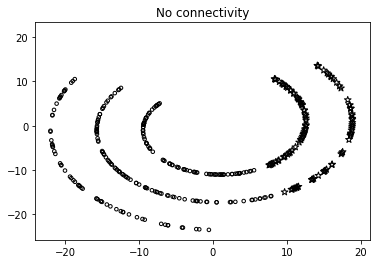

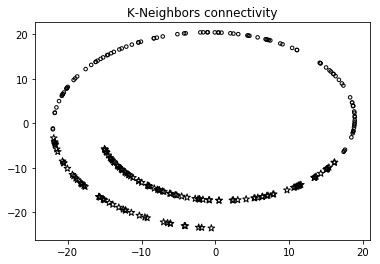

In [92]:
from sklearn.cluster import AgglomerativeClustering
from sklearn.neighbors import kneighbors_graph
n_samples = 500
np.random.seed(2)
t = 2.5 * np.pi * (1 + 2 * np.random.rand(1, n_samples))
X = get_sprial(t)
# 不考虑螺旋形的数据连接性
connectivity = None
perform_clustering(X, connectivity, 'No connectivity')
# 根据数据连接线创建K个临近点的图形
connectivity = kneighbors_graph(X, 10, include_self=False) 
perform_clustering(X, connectivity, 'K-Neighbors connectivity')

## 4.6 评价聚类算法的效果
轮廓系数
簇内平均距离(凝聚度) 簇间平局距离(离散度)

In [93]:
data=pd.read_csv('data_pref.txt',header=None)
data.head()

,0,1
0,1.65,1.91
1,2.77,4.98
2,5.82,2.56
3,7.24,5.24
4,-0.30,4.06


Number of cluster 2
silouette score 0.5290397175472954
Number of cluster 3
silouette score 0.5494898511995374
Number of cluster 4
silouette score 0.5832757517829593
Number of cluster 5
silouette score 0.6582796909760834
Number of cluster 6
silouette score 0.5984130334897403
Number of cluster 7
silouette score 0.5199401859388386
Number of cluster 8
silouette score 0.45912480909034686
Number of cluster 9
silouette score 0.45219349812398585


Text(0.5,1,'silhouette score with num of cluster')

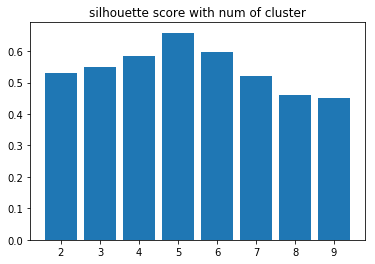

In [96]:
from sklearn.metrics import silhouette_score
scores=[]
range_num_k=np.arange(2,10)
for i in range_num_k:
    kmeans=KMeans(init='k-means++',n_clusters=i,n_init=10)
    kmeans.fit(data)
    score=silhouette_score(data,kmeans.labels_,metric='euclidean',sample_size=len(data))
    print('Number of cluster',i)
    print('silouette score',score)
    scores.append(score)
plt.bar(range_num_k,scores)
plt.title('silhouette score with num of cluster')


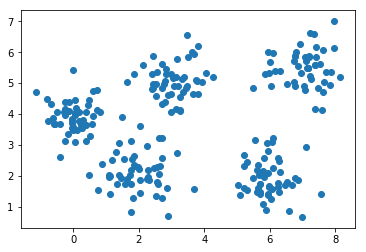

In [97]:
plt.scatter(data[0],data[1])

## 4.7 用DBSCAN算法自动估算集群数量
介绍k-means算法的时候，必须把集群数量当作一个输入参数。在真实世界中，我们事先并 不知道这个信息。可以搜索集群数量的参数空间，通过轮廓系数得分找到最优的集群数量，但这 是一个非常耗时的过程。难道就没有一种方法可以直接找出集群数量吗?DBSCAN(Density- Based Spatial Clustering of Applications with Noise，带噪声的基于密度的聚类方法)应运而生。  
DBSCAN将数据点看成是紧密集群的若干组。如果某个点属于一个集群，那么就应该有许多 点也属于同一个集群。该方法里面有一个epsilon参数，可以控制这个点到其他点的最大距离。 如果两个点的距离超过了参数epsilon的值，它们就不可能在一个集群中。你可以在 http://staffwww.itn.liu.se/~aidvi/courses/06/dm/Seminars2011/DBSCAN(4).pdf学习更多的内容。这种 方法的主要优点是它可以处理异常点。如果有一些点位于数据稀疏区域，DBSCAN就会把这些点 作为异常点，而不会强制将它们放入一个集群中。